In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib as mpl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import seaborn as sns
plt.rcParams.update({
    "figure.dpi": 150,   # higher resolution
    "font.size": 11,     # larger fonts
})

## Choose Dataset

In [6]:
time_step =212
phi = 0.40
lat_size = "100"
T_ref = 300
p_ref = 5e05

isolevels = [3, 3.5, 3.8, 4, 4.1,4.2, 4.3, 4.4 ,4.5, 4.7]
n_isolevels = len(isolevels)

multiple_runs= False
n_RUN = 3

Soret_term = False
Soret_positive = False
post = True


## Clustering Parameters

In [7]:
feature_setting = 1
n_clusters = 8

phi0.40/h400x100_ref
Timestep: 212
Isolevels: [3, 3.5, 3.8, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.7]
Number of clusters 8
Feature setting: reaction


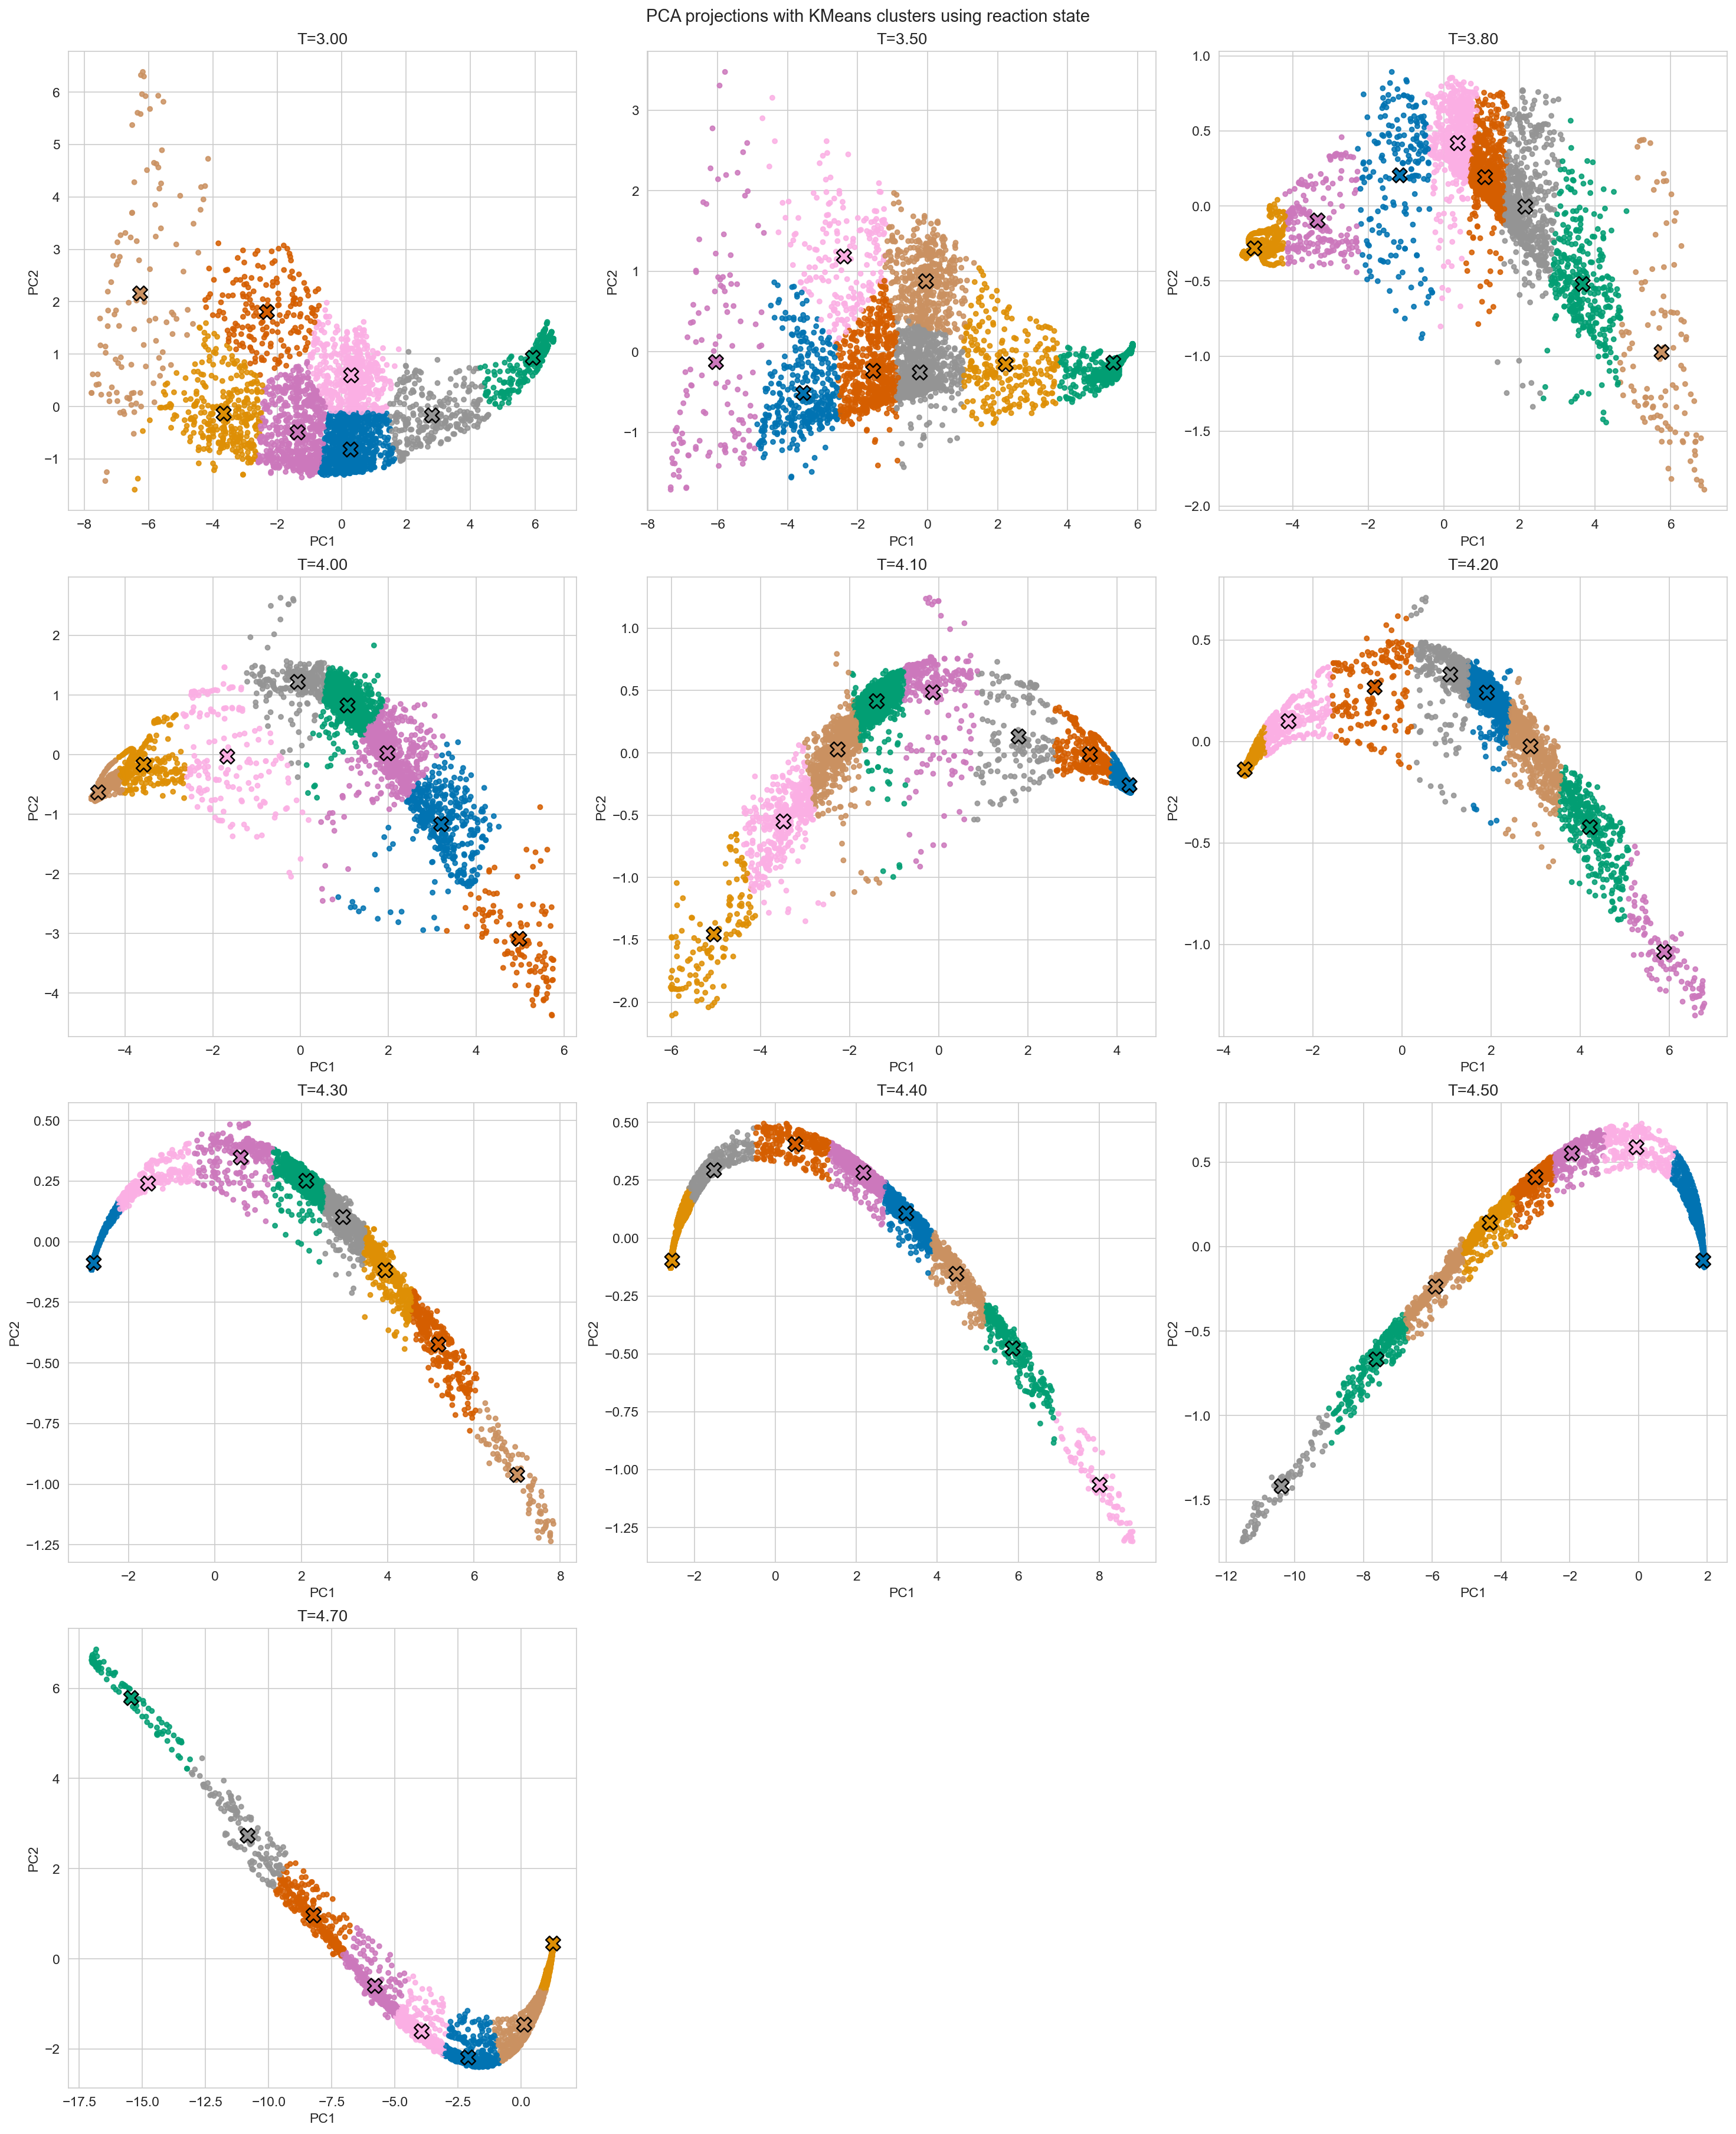

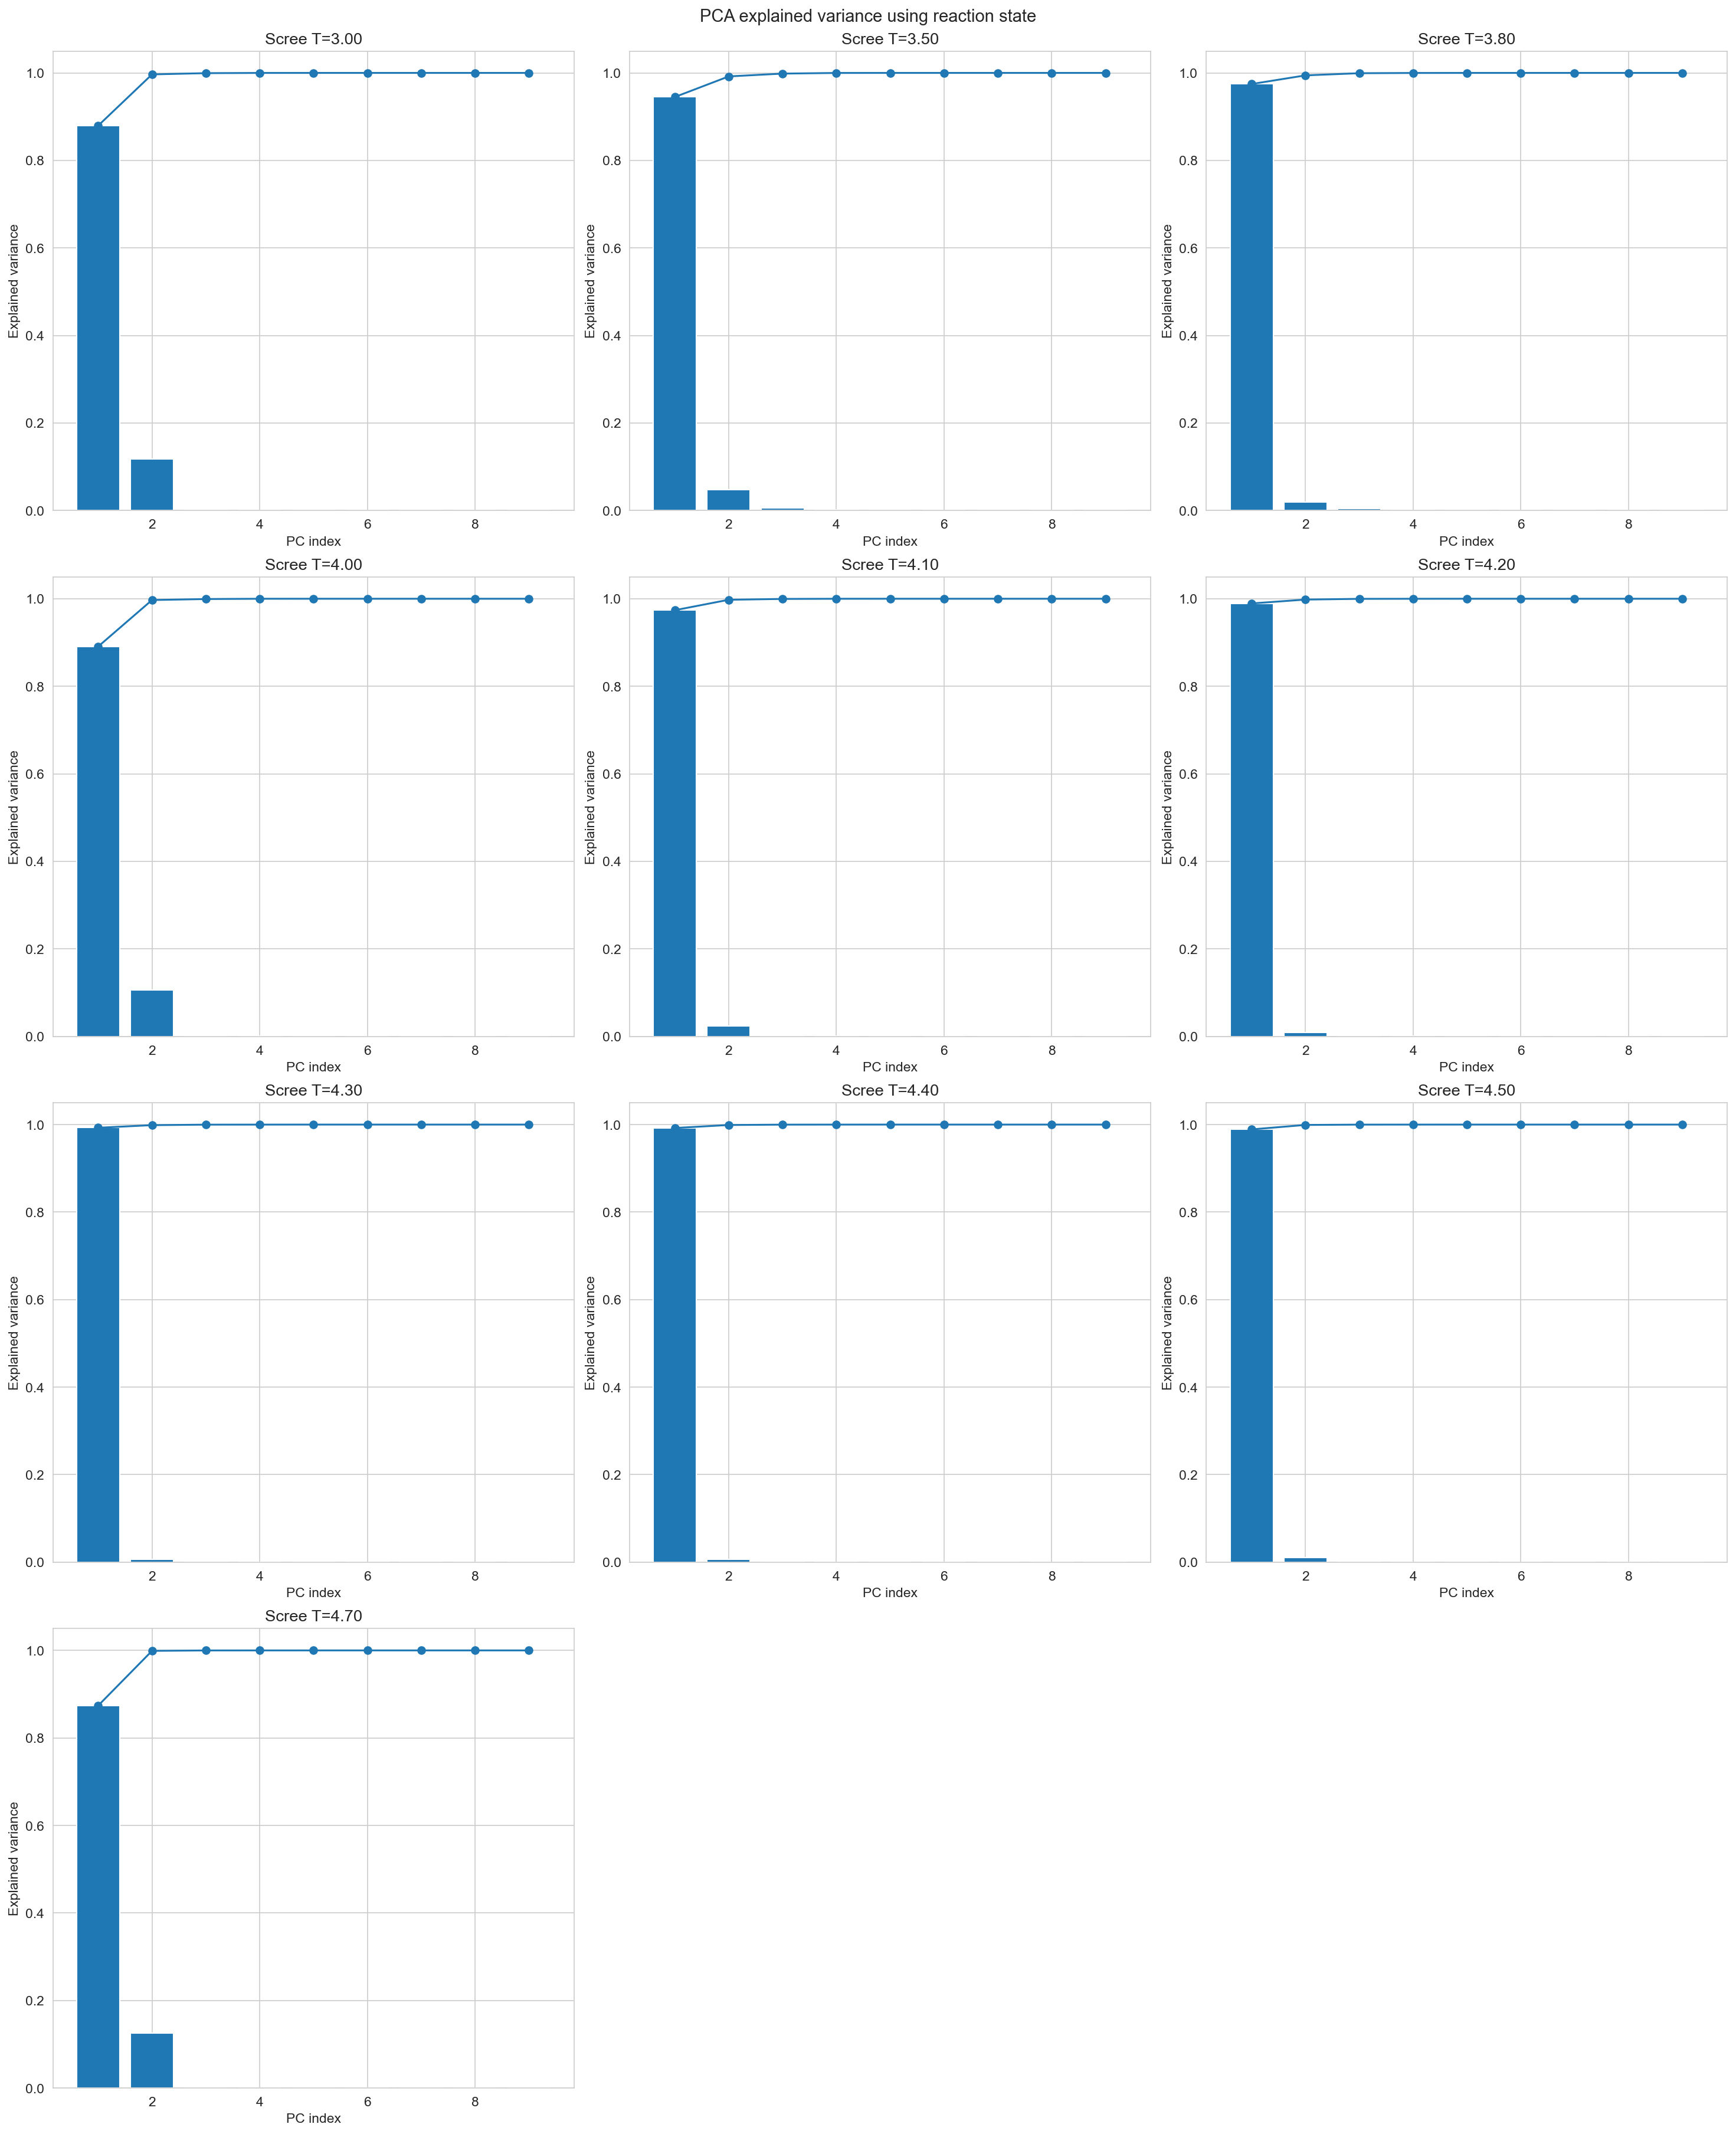

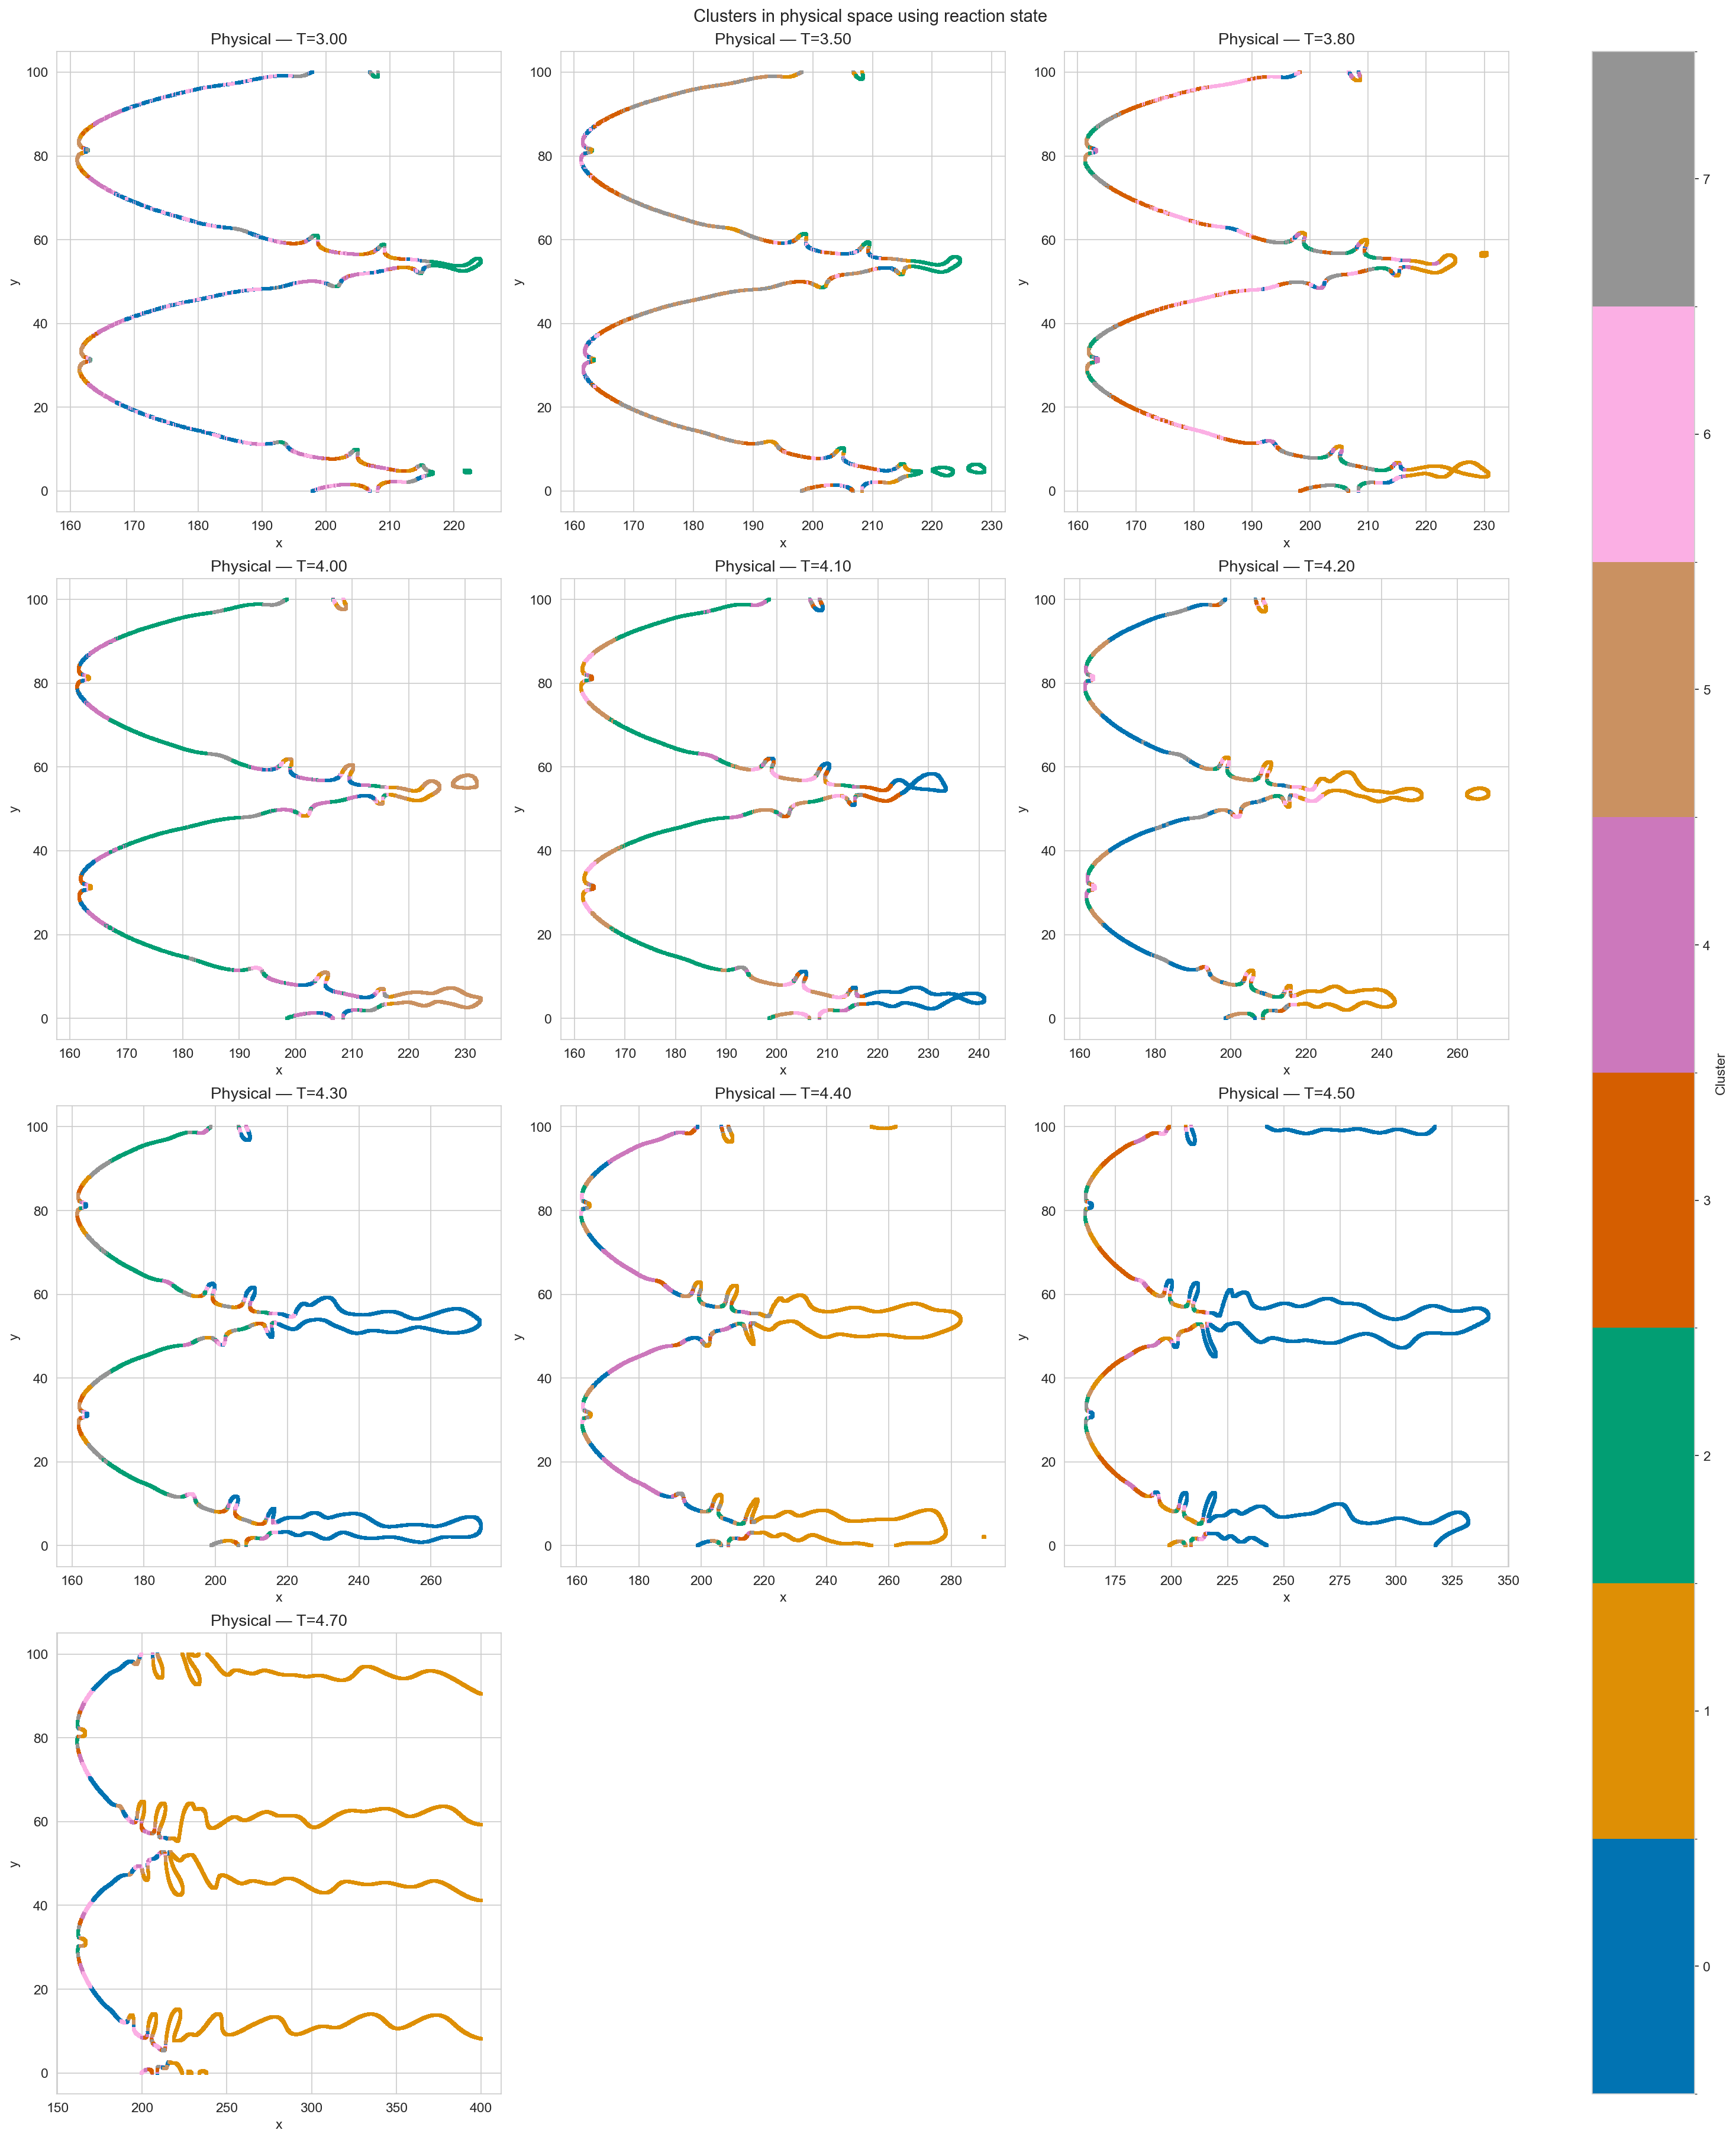

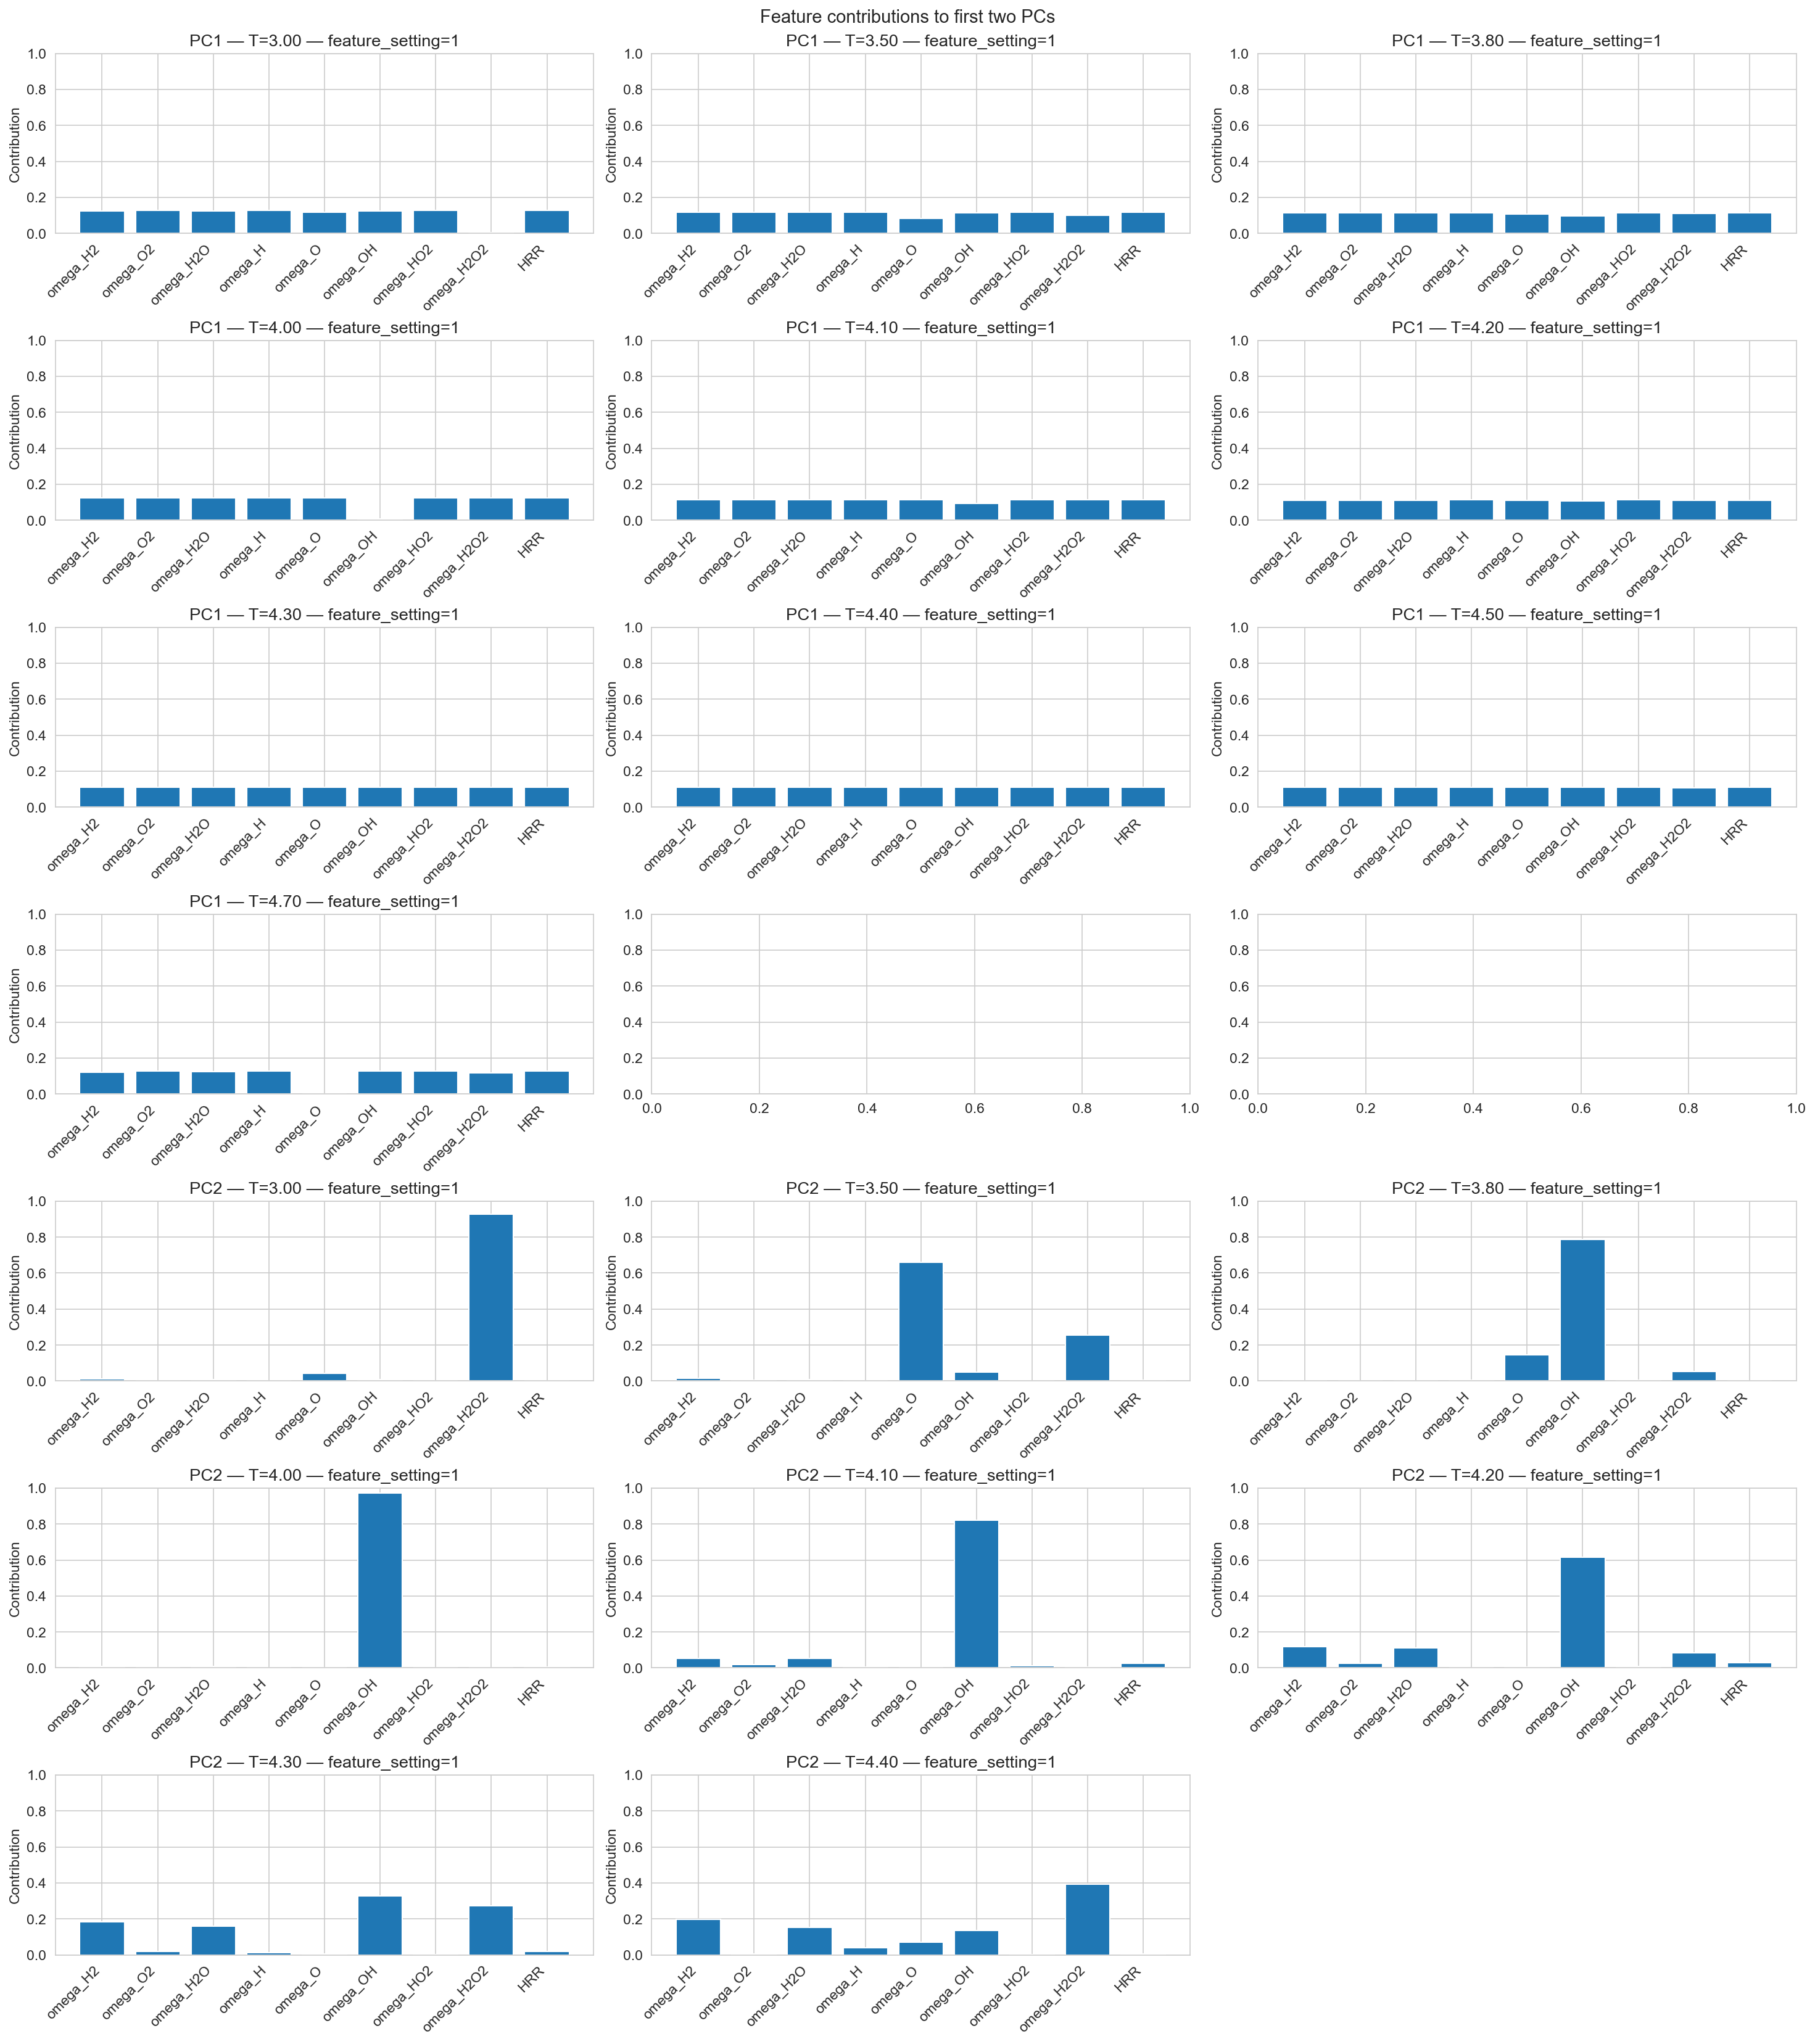

In [8]:
# ============================================================
# STORAGE DICTIONARY FOR LATER USE
# ============================================================
all_cluster_results = {}
if feature_setting:
    plot_title = "reaction"
else:
    plot_title = "state"

n_iso = len(isolevels)
print(f"phi{phi:.2f}/h400x{lat_size}_ref")
print(f"Timestep: {time_step}")
print(f"Isolevels: {isolevels}")
print(f"Number of clusters {n_clusters}")
print(f"Feature setting: {plot_title}")

# --------------------------------------------------------------
# Figure layout that works for ANY n_iso
# --------------------------------------------------------------

# For PCA / scree / physical plots: up to 3 columns, as many rows as needed
ncols_main = min(3, n_iso)
nrows_main = math.ceil(n_iso / ncols_main)

fig_pca, axs_pca = plt.subplots(
    nrows_main, ncols_main, figsize=(6.5 * ncols_main, 6 * nrows_main),
    constrained_layout=True, squeeze=False
)
fig_scree, axs_scree = plt.subplots(
    nrows_main, ncols_main, figsize=(6.5 * ncols_main, 6 * nrows_main),
    constrained_layout=True, squeeze=False
)
fig_phys, axs_phys = plt.subplots(
    nrows_main, ncols_main, figsize=(6.5 * ncols_main, 6 * nrows_main),
    constrained_layout=True, squeeze=False
)

# For loadings: same column layout as main plots,
# with PC1 in the upper block and PC2 in the lower block
ncols_load = ncols_main
nrows_load = 2 * nrows_main  # first block for PC1, second for PC2

fig_load, axs_load = plt.subplots(
    nrows_load, ncols_load,
    figsize=(6.5 * ncols_load, 3.0 * nrows_load),
    constrained_layout=True,
    squeeze=False
)

colors = sns.color_palette("colorblind", n_clusters)
cmap_clusters = ListedColormap(colors)
bounds = np.arange(-0.5, n_clusters + 0.5, 1)
norm_clusters = BoundaryNorm(bounds, cmap_clusters.N)


# --------------------------------------------------------------
# Select features
# --------------------------------------------------------------
if feature_setting == 0:
    features = ['H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2']
else:
    features = [
        'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
        'omega_HO2', 'omega_H2O2', 'HRR'
    ]
if (Soret_term & Soret_positive):
    save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret_positive"
elif Soret_term:
    save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret"
else:
    save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref"
if multiple_runs:
    save_name += f"/RUN0{n_RUN}"
# --------------------------------------------------------------
# Loop over isocontours
# --------------------------------------------------------------
for c_idx, c_val in enumerate(isolevels):

    # compute row/col in the main grids
    row = c_idx // ncols_main
    col = c_idx % ncols_main
    if post:
        save_file_name = f"/extracted_flame_front_post_{time_step}_iso_{c_val}.csv"
    else:
        save_file_name = f"/extracted_flame_front_{time_step}_iso_{c_val}.csv"
    save_name_iso = save_name + save_file_name
    front = pd.read_csv(save_name_iso)

    X_raw = front[features].to_numpy()

    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(n_clusters=n_clusters, init="k-means++", n_init=20,
               max_iter=300, random_state=0)
    )
    labels = pipe.fit_predict(X_raw)

    scaler = pipe.named_steps["standardscaler"]
    centroids_scaled = pipe.named_steps["kmeans"].cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    X_scaled = scaler.transform(X_raw)

    # ----------------------------------------------------------
    # PCA
    # ----------------------------------------------------------
    pca = PCA(n_components=None, random_state=0)
    X2d = pca.fit_transform(X_scaled)
    centroids2d = pca.transform(centroids_scaled)

    loadings = pca.components_[:2, :]
    contrib = loadings ** 2
    contrib = contrib / contrib.sum(axis=1, keepdims=True)

    # ----------------------------------------------------------
    # STORE RESULTS for LATER USE
    # ----------------------------------------------------------
    all_cluster_results[c_val] = {
        "front": front,
        "labels": labels,
        "X_raw": X_raw,
        "X_scaled": X_scaled,
        "centroids_scaled": centroids_scaled,
        "centroids_unscaled": centroids_unscaled,
        "X2d": X2d,
        "centroids2d": centroids2d,
        "scaler": scaler,
        "pca": pca,
        "pipe": pipe,
        "features": features,
        "contrib": contrib,
    }

    # ----------------------------------------------------------
    # PCA plot
    # ----------------------------------------------------------
    axp = axs_pca[row, col]
    sc_pca = axp.scatter(
        X2d[:, 0], X2d[:, 1],
        c=labels, cmap=cmap_clusters, norm=norm_clusters,
        s=14, alpha=0.85
    )
    axp.scatter(
        centroids2d[:, 0], centroids2d[:, 1],
        c=np.arange(n_clusters), cmap=cmap_clusters, norm=norm_clusters,
        s=140, marker="X", edgecolor="k", linewidths=1.2
    )
    axp.set_title(f"T={c_val:.2f}")
    axp.set_xlabel("PC1")
    axp.set_ylabel("PC2")

    # Scree
    evr = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    axs_scr = axs_scree[row, col]
    idx = np.arange(1, len(evr) + 1)
    axs_scr.bar(idx, evr)
    axs_scr.plot(idx, cum_evr, marker="o")
    axs_scr.set_title(f"Scree T={c_val:.2f}")
    axs_scr.set_xlabel("PC index")
    axs_scr.set_ylabel("Explained variance")

    # ----------------------------------------------------------
    # Feature contributions (PC1, PC2), over multiple rows
    # ----------------------------------------------------------
    for pc_idx, pc_name in enumerate(["PC1", "PC2"]):
        # block 0..(nrows_main-1): PC1, block nrows_main..(2*nrows_main-1): PC2
        row_load = pc_idx * nrows_main + row
        col_load = col

        ax_l = axs_load[row_load, col_load]
        ax_l.bar(np.arange(len(features)), contrib[pc_idx])
        ax_l.set_xticks(np.arange(len(features)))
        ax_l.set_xticklabels(features, rotation=45, ha="right")
        ax_l.set_ylabel("Contribution")
        ax_l.set_ylim(0, 1)
        ax_l.set_title(f"{pc_name} — T={c_val:.2f} — feature_setting={feature_setting}")

    # Physical space plot
    ax_phys = axs_phys[row, col]
    ax_phys.scatter(
        front['x'], front['y'],
        c=labels,
        cmap=cmap_clusters, norm=norm_clusters,
        s=8, marker='s', linewidths=0
    )
    ax_phys.set_xlabel("x")
    ax_phys.set_ylabel("y")
    ax_phys.set_title(f"Physical — T={c_val:.2f}")

# --------------------------------------------------------------
# Hide unused axes in main grids (if any)
# --------------------------------------------------------------
total_slots = nrows_main * ncols_main
for dummy_idx in range(n_iso, total_slots):
    r = dummy_idx // ncols_main
    c = dummy_idx % ncols_main
    axs_pca[r, c].set_visible(False)
    axs_scree[r, c].set_visible(False)
    axs_phys[r, c].set_visible(False)

# Hide unused axes in loadings grid (if any)
total_slots_load = nrows_load * ncols_load
used_slots_load = 2 * n_iso  # PC1 + PC2 per isolevel
for dummy_idx in range(used_slots_load, total_slots_load):
    r = dummy_idx // ncols_load
    c = dummy_idx % ncols_load
    axs_load[r, c].set_visible(False)

# Shared colourbar
cb = fig_phys.colorbar(
    mpl.cm.ScalarMappable(norm=norm_clusters, cmap=cmap_clusters),
    ax=axs_phys.ravel().tolist(),
    ticks=np.arange(n_clusters)
)
cb.set_label("Cluster")

fig_pca.suptitle(f"PCA projections with KMeans clusters using {plot_title} state", fontsize=14)
fig_scree.suptitle(f"PCA explained variance using {plot_title} state", fontsize=14)
fig_phys.suptitle(f"Clusters in physical space using {plot_title} state", fontsize=14)
fig_load.suptitle("Feature contributions to first two PCs", fontsize=14)

plt.show()




## Sd vs Stretch, conditioned on different clusters and isotherms

In [35]:
var_x = "curvature"
var_y = "DW_FDS"

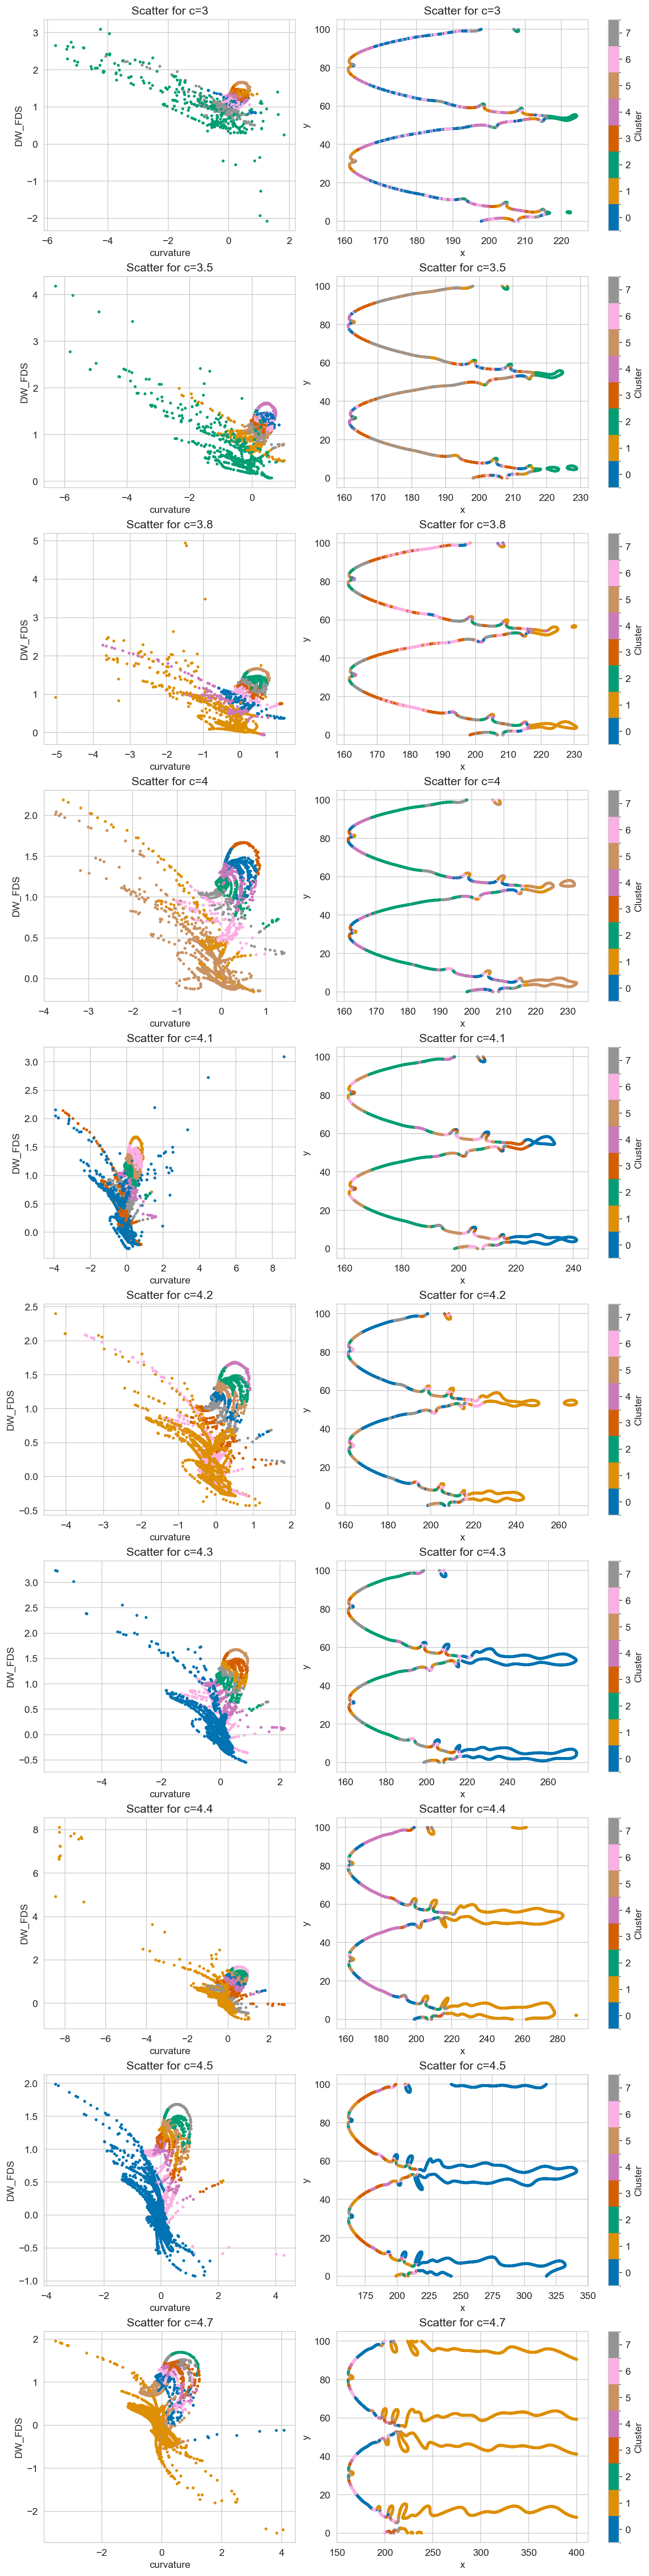

In [36]:

fig, axs = plt.subplots(n_isolevels, 2, figsize=(10, 40), constrained_layout=True)

for idx, c_val in enumerate(isolevels):
    res = all_cluster_results[c_val]

    front  = res["front"]
    labels = res["labels"]

    # choose the axis for this isolevel
    ax = axs[idx, 0]   # left column for scatter
    sc = ax.scatter(
        front[var_x], front[var_y],
        c=labels, cmap=cmap_clusters, norm=norm_clusters, s=5
    )
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.set_title(f"Scatter for c={c_val}")

        # choose the axis for this isolevel
    ax = axs[idx, 1]   # left column for scatter
    sc = ax.scatter(
        front["x"], front["y"],
        c=labels, cmap=cmap_clusters, norm=norm_clusters, s=5
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Scatter for c={c_val}")

    # Add colorbar ONCE per subplot
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm_clusters, cmap=cmap_clusters),
        ax=ax,
        ticks=np.arange(n_clusters)
    )
    cb.set_label("Cluster")

plt.show()



## Corellation of two variables using all isotherms

In [37]:
var_x = "stretch_rate"
var_y = "DW_FDS"

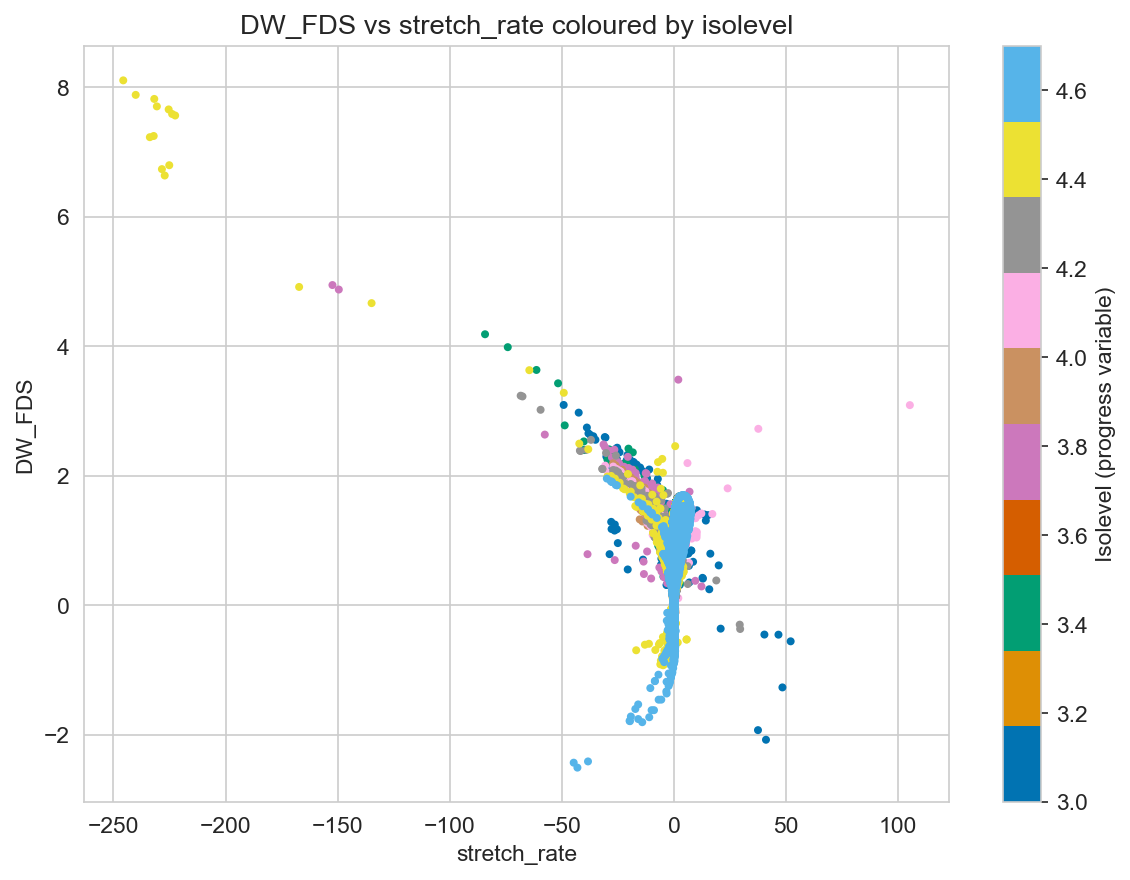

In [38]:
iso_min = min(isolevels)
iso_max = max(isolevels)

cmap_iso = ListedColormap(sns.color_palette("colorblind", len(isolevels)))

fig, ax = plt.subplots(figsize=(8, 6))

for c_val in isolevels:
    res = all_cluster_results[c_val]
    front = res["front"]

    # Colour by the actual isolevel c_val
    ax.scatter(
        front[var_x],
        front[var_y],
        c=np.full(len(front), c_val),
        cmap=cmap_iso,
        s=8,
        vmin=iso_min,
        vmax=iso_max,
    )

# ---------------------------------------
# Colorbar using REAL isolevel values
# ---------------------------------------
mappable = plt.cm.ScalarMappable(
    cmap=cmap_iso,
    norm=plt.Normalize(vmin=iso_min, vmax=iso_max)
)
mappable.set_array([])

cbar = fig.colorbar(mappable, ax=ax)
cbar.set_label("Isolevel (progress variable)")

ax.set_xlabel(var_x)
ax.set_ylabel(var_y)
ax.set_title(f"{var_y} vs {var_x} coloured by isolevel")

plt.tight_layout()
plt.show()


In [39]:
# Bright categorical palette that works on flames
palette = sns.color_palette("colorblind", n_clusters)

# Convert to Plotly-style colourscale
colorscale = [
    [i/(n_clusters-1), f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"]
    for i, (r, g, b) in enumerate(palette)
]
def interactive_front_plotly(res, var_x="H2", var_y="H2O", c_val=None):
    """
    res: all_cluster_results[c_val], with keys:
         - "front": DataFrame with columns ["x", "y", var_x, var_y, ...]
         - "labels": cluster labels (array-like)

    Interaction:
        - Click/tap on the physical-space plot (left) OR the state-space plot (right).
        - The clicked point index is used (Plotly gives it directly).
        - The corresponding point is highlighted in both plots.
    """

    front  = res["front"]
    labels = np.asarray(res["labels"])

    x_arr  = front["x"].to_numpy()
    y_arr  = front["y"].to_numpy()
    Xv_arr = front[var_x].to_numpy()
    Yv_arr = front[var_y].to_numpy()

    # ---- create subplots ----
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=(
            f"Physical space (flame front){'' if c_val is None else f' (c = {c_val})'}",
            f"State space ({var_x} vs {var_y}){'' if c_val is None else f' (c = {c_val})'}"
        )
    )

    # ---- base scatter: physical space ----
    sc_phys = go.Scatter(
        x=x_arr,
        y=y_arr,
        mode="markers",
        marker=dict(
            color=labels,
            colorscale=colorscale,
            cmin=0,
            cmax=n_clusters-1,
            size=6,
            showscale=True
        ),
        name="Physical",
        hovertemplate="x=%{x:.4f}<br>y=%{y:.4f}<br>cluster=%{marker.color}<extra></extra>"
    )
    fig.add_trace(sc_phys, row=1, col=1)

    # ---- base scatter: state space ----
    sc_state = go.Scatter(
        x=Xv_arr,
        y=Yv_arr,
        mode="markers",
        marker=dict(
            color=labels,
            colorscale=colorscale,
            cmin=0,
            cmax=n_clusters-1,
            size=6,
            showscale=False
        ),
        name="State",
        hovertemplate=(
            f"{var_x}=%{{x:.4e}}<br>{var_y}=%{{y:.4e}}"
            "<br>cluster=%{marker.color}<extra></extra>"
        )
    )
    fig.add_trace(sc_state, row=1, col=2)

    # ---- highlight markers (initially first point) ----
    idx0 = 0
    sel_phys = go.Scatter(
        x=[x_arr[idx0]],
        y=[y_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2),
        ),
        name="Selected (phys)",
        showlegend=False
    )
    sel_state = go.Scatter(
        x=[Xv_arr[idx0]],
        y=[Yv_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2),
        ),
        name="Selected (state)",
        showlegend=False
    )
    fig.add_trace(sel_phys,  row=1, col=1)
    fig.add_trace(sel_state, row=1, col=2)

    # convert to FigureWidget to enable callbacks
    fig = go.FigureWidget(fig)

    # references to traces (order: phys, state, sel_phys, sel_state)
    tr_phys      = fig.data[0]
    tr_state     = fig.data[1]
    tr_sel_phys  = fig.data[2]
    tr_sel_state = fig.data[3]

    # ---- click callback (used for both plots) ----
    def update_selected(trace, points, selector):
        if not points.point_inds:
            return
        idx = int(points.point_inds[0])

        with fig.batch_update():
            tr_sel_phys.x  = [x_arr[idx]]
            tr_sel_phys.y  = [y_arr[idx]]
            tr_sel_state.x = [Xv_arr[idx]]
            tr_sel_state.y = [Yv_arr[idx]]

    # attach callback to BOTH traces
    tr_phys.on_click(update_selected)
    tr_state.on_click(update_selected)

    # ---- axes / layout ----
    fig.update_xaxes(title_text="x", row=1, col=1)
    fig.update_yaxes(title_text="y", row=1, col=1)

    fig.update_xaxes(title_text=var_x, row=1, col=2)
    fig.update_yaxes(title_text=var_y, row=1, col=2)

    fig.update_layout(
        height=600,
        width=1300,
        margin=dict(l=60, r=40, t=60, b=40)
    )

    return fig




In [40]:
c_val = isolevels[-5]
res   = all_cluster_results[c_val]

fig = interactive_front_plotly(
    res,
    var_x="stretch_rate",
    var_y="DW_FDS",
    c_val=c_val
)
fig  # in a notebook, this will display the interactive widget


FigureWidget({
    'data': [{'hovertemplate': 'x=%{x:.4f}<br>y=%{y:.4f}<br>cluster=%{marker.color}<extra></extra>',
              'marker': {'cmax': 7,
                         'cmin': 0,
                         'color': {'bdata': ('AQAAAAEAAAABAAAAAQAAAAEAAAABAA' ... 'AAAQAAAAEAAAABAAAAAQAAAAEAAAA='),
                                   'dtype': 'i4'},
                         'colorscale': [[0.0, 'rgb(1, 115, 178)'],
                                        [0.14285714285714285, 'rgb(222, 143, 5)'],
                                        [0.2857142857142857, 'rgb(2, 158, 115)'],
                                        [0.42857142857142855, 'rgb(213, 94, 0)'],
                                        [0.5714285714285714, 'rgb(204, 120, 188)'],
                                        [0.7142857142857143, 'rgb(202, 145, 97)'],
                                        [0.8571428571428571, 'rgb(251, 175, 228)'],
                                        [1.0, 'rgb(148, 148, 148)']],
         

In [41]:
# Bright categorical palette that works on flames
palette = sns.color_palette("colorblind", n_clusters)

def interactive_front_single_cluster_plotly(res, cluster_id, var_x="H2", var_y="H2O", c_val=None):
    """
    Same as interactive_front_plotly, but plots ONLY one cluster (cluster_id)
    for a single isotherm (already selected when building `res`).

    Parameters
    ----------
    res : dict
        all_cluster_results[c_val] with keys:
          - "front": DataFrame with columns ["x", "y", var_x, var_y, ...]
          - "labels": cluster labels (array-like)
    cluster_id : int
        ID of the cluster to plot.
    """

    front  = res["front"]
    labels = np.asarray(res["labels"])

    # ---- filter to the chosen cluster ----
    mask = (labels == cluster_id)
    if not np.any(mask):
        raise ValueError(f"No points found for cluster {cluster_id} in this isotherm.")

    x_arr  = front.loc[mask, "x"].to_numpy()
    y_arr  = front.loc[mask, "y"].to_numpy()
    Xv_arr = front.loc[mask, var_x].to_numpy()
    Yv_arr = front.loc[mask, var_y].to_numpy()

    # pick one color for this cluster from the palette
    r, g, b = palette[cluster_id]
    cluster_color = f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

    # ---- create subplots ----
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=(
            f"Physical space (cluster {cluster_id})"
            f"{'' if c_val is None else f' – c = {c_val}'}",
            f"State space ({var_x} vs {var_y}, cluster {cluster_id})"
            f"{'' if c_val is None else f' – c = {c_val}'}"
        )
    )

    # ---- base scatter: physical space ----
    sc_phys = go.Scatter(
        x=x_arr,
        y=y_arr,
        mode="markers",
        marker=dict(
            color=cluster_color,
            size=6,
        ),
        name=f"Cluster {cluster_id} (phys)",
        hovertemplate="x=%{x:.4f}<br>y=%{y:.4f}<extra></extra>"
    )
    fig.add_trace(sc_phys, row=1, col=1)

    # ---- base scatter: state space ----
    sc_state = go.Scatter(
        x=Xv_arr,
        y=Yv_arr,
        mode="markers",
        marker=dict(
            color=cluster_color,
            size=6,
        ),
        name=f"Cluster {cluster_id} (state)",
        hovertemplate=(
            f"{var_x}=%{{x:.4e}}<br>{var_y}=%{{y:.4e}}<extra></extra>"
        )
    )
    fig.add_trace(sc_state, row=1, col=2)

    # ---- highlight markers (initially first point) ----
    idx0 = 0
    sel_phys = go.Scatter(
        x=[x_arr[idx0]],
        y=[y_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2, color="black"),
        ),
        name="Selected (phys)",
        showlegend=False
    )
    sel_state = go.Scatter(
        x=[Xv_arr[idx0]],
        y=[Yv_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2, color="black"),
        ),
        name="Selected (state)",
        showlegend=False
    )
    fig.add_trace(sel_phys,  row=1, col=1)
    fig.add_trace(sel_state, row=1, col=2)

    # convert to FigureWidget to enable callbacks
    fig = go.FigureWidget(fig)

    # references to traces (order: phys, state, sel_phys, sel_state)
    tr_phys      = fig.data[0]
    tr_state     = fig.data[1]
    tr_sel_phys  = fig.data[2]
    tr_sel_state = fig.data[3]

    # ---- click callback (used for both plots) ----
    def update_selected(trace, points, selector):
        if not points.point_inds:
            return
        idx = int(points.point_inds[0])

        with fig.batch_update():
            tr_sel_phys.x  = [x_arr[idx]]
            tr_sel_phys.y  = [y_arr[idx]]
            tr_sel_state.x = [Xv_arr[idx]]
            tr_sel_state.y = [Yv_arr[idx]]

    # attach callback to BOTH traces
    tr_phys.on_click(update_selected)
    tr_state.on_click(update_selected)

    # ---- axes / layout ----
    fig.update_xaxes(title_text="x", row=1, col=1)
    fig.update_yaxes(title_text="y", row=1, col=1)

    fig.update_xaxes(title_text=var_x, row=1, col=2)
    fig.update_yaxes(title_text=var_y, row=1, col=2)

    fig.update_layout(
        height=600,
        width=1400,
        margin=dict(l=60, r=40, t=60, b=40)
    )

    return fig


In [42]:
c_val = isolevels[-2]                      # choose isotherm
res   = all_cluster_results[c_val]
cluster_id = 0                        # choose cluster index

fig = interactive_front_single_cluster_plotly(
    res,
    cluster_id=cluster_id,
    var_x="curvature",
    var_y="DW_FDS",
    c_val=c_val
)
fig


FigureWidget({
    'data': [{'hovertemplate': 'x=%{x:.4f}<br>y=%{y:.4f}<extra></extra>',
              'marker': {'color': 'rgb(1, 115, 178)', 'size': 6},
              'mode': 'markers',
              'name': 'Cluster 0 (phys)',
              'type': 'scatter',
              'uid': '3fced809-261f-4557-b746-172df3167e01',
              'x': {'bdata': ('AQAAwMzMaEBR/cRPXs1oQAEAACBxzm' ... 'AAoLijbUD+//8/FKltQAEAAOA9m21A'),
                    'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': ('AbotCYB4T0AAAACgO3pPQDTLRb2hfU' ... 'KnI22K+z+Jsv80kcf6Py0LCC47p/w/'),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'hovertemplate': 'curvature=%{x:.4e}<br>DW_FDS=%{y:.4e}<extra></extra>',
              'marker': {'color': 'rgb(1, 115, 178)', 'size': 6},
              'mode': 'markers',
              'name': 'Cluster 0 (state)',
              'type': 'scatter',
              'uid': 'c78fa5b9-c3b8-4bea-a86d-aee44e0f1abe',
              'x': {

In [43]:

def cluster_front_by_xy(res, cluster_id, n_xy_clusters=4, random_state=0):
    """
    Take a single isotherm result 'res' and an original cluster_id,
    and perform KMeans clustering in (x, y) on that subset.

    Returns
    -------
    sub_front : DataFrame (only points of this cluster, with new 'xy_cluster' column)
    """
    front  = res["front"]
    labels = np.asarray(res["labels"])

    # ---- filter to the chosen original cluster ----
    mask = (labels == cluster_id)
    if not np.any(mask):
        raise ValueError(f"No points found for cluster {cluster_id} in this isotherm.")

    sub_front = front.loc[mask].reset_index(drop=True)

    # KMeans in (x, y)
    coords = sub_front[["x", "y"]].to_numpy()
    kmeans = KMeans(n_clusters=n_xy_clusters, random_state=random_state, n_init=10)
    xy_labels = kmeans.fit_predict(coords)

    sub_front["xy_cluster"] = xy_labels
    return sub_front


In [44]:


def interactive_front_xy_clusters_plotly(sub_front, var_x="H2", var_y="H2O", c_val=None):
    """
    Interactive plot of a single front subset, coloured by 'xy_cluster'.

    sub_front must have columns: 'x', 'y', var_x, var_y, 'xy_cluster'.
    """

    x_arr  = sub_front["x"].to_numpy()
    y_arr  = sub_front["y"].to_numpy()
    Xv_arr = sub_front[var_x].to_numpy()
    Yv_arr = sub_front[var_y].to_numpy()
    xy_labels = sub_front["xy_cluster"].to_numpy()

    # number of spatial clusters
    n_xy_clusters = int(xy_labels.max()) + 1

    # bright categorical palette for the new clusters
    palette_xy = sns.color_palette("colorblind", n_xy_clusters)
    colorscale_xy = [
        [i / max(1, (n_xy_clusters - 1)),
         f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"]
        for i, (r, g, b) in enumerate(palette_xy)
    ]

    # ---- create subplots ----
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=(
            f"Physical space (xy-clusters){'' if c_val is None else f' – c = {c_val}'}",
            f"State space ({var_x} vs {var_y}, xy-clusters){'' if c_val is None else f' – c = {c_val}'}"
        )
    )

    # ---- base scatter: physical space ----
    sc_phys = go.Scatter(
        x=x_arr,
        y=y_arr,
        mode="markers",
        marker=dict(
            color=xy_labels,
            colorscale=colorscale_xy,
            cmin=0,
            cmax=n_xy_clusters - 1,
            size=6,
            showscale=True,
            colorbar=dict(title="xy-cluster")
        ),
        name="Physical (xy-cluster)",
        hovertemplate="x=%{x:.4f}<br>y=%{y:.4f}<br>xy_cluster=%{marker.color}<extra></extra>"
    )
    fig.add_trace(sc_phys, row=1, col=1)

    # ---- base scatter: state space ----
    sc_state = go.Scatter(
        x=Xv_arr,
        y=Yv_arr,
        mode="markers",
        marker=dict(
            color=xy_labels,
            colorscale=colorscale_xy,
            cmin=0,
            cmax=n_xy_clusters - 1,
            size=6,
            showscale=False
        ),
        name="State (xy-cluster)",
        hovertemplate=(
            f"{var_x}=%{{x:.4e}}<br>{var_y}=%{{y:.4e}}"
            "<br>xy_cluster=%{marker.color}<extra></extra>"
        )
    )
    fig.add_trace(sc_state, row=1, col=2)

    # ---- highlight markers (initially first point) ----
    idx0 = 0
    sel_phys = go.Scatter(
        x=[x_arr[idx0]],
        y=[y_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2, color="black"),
        ),
        name="Selected (phys)",
        showlegend=False
    )
    sel_state = go.Scatter(
        x=[Xv_arr[idx0]],
        y=[Yv_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2, color="black"),
        ),
        name="Selected (state)",
        showlegend=False
    )
    fig.add_trace(sel_phys,  row=1, col=1)
    fig.add_trace(sel_state, row=1, col=2)

    # convert to FigureWidget for callbacks
    fig = go.FigureWidget(fig)

    tr_phys      = fig.data[0]
    tr_state     = fig.data[1]
    tr_sel_phys  = fig.data[2]
    tr_sel_state = fig.data[3]

    def update_selected(trace, points, selector):
        if not points.point_inds:
            return
        idx = int(points.point_inds[0])
        with fig.batch_update():
            tr_sel_phys.x  = [x_arr[idx]]
            tr_sel_phys.y  = [y_arr[idx]]
            tr_sel_state.x = [Xv_arr[idx]]
            tr_sel_state.y = [Yv_arr[idx]]

    tr_phys.on_click(update_selected)
    tr_state.on_click(update_selected)

    # ---- axes / layout ----
    fig.update_xaxes(title_text="x", row=1, col=1)
    fig.update_yaxes(title_text="y", row=1, col=1)

    fig.update_xaxes(title_text=var_x, row=1, col=2)
    fig.update_yaxes(title_text=var_y, row=1, col=2)

    fig.update_layout(
        height=600,
        width=1400,
        margin=dict(l=60, r=40, t=60, b=40)
    )

    return fig


In [45]:
# choose isotherm and original cluster
c_val = isolevels[-2]
res   = all_cluster_results[c_val]
cluster_id = 5

# 1) spatial clustering in (x, y) for this front segment
sub_front = cluster_front_by_xy(res, cluster_id=cluster_id, n_xy_clusters=15)

# 2) interactive plot, coloured by new xy-clusters
fig_xy = interactive_front_xy_clusters_plotly(
    sub_front,
    var_x="stretch_rate",
    var_y="DW_FDS",
    c_val=c_val
)
fig_xy


FigureWidget({
    'data': [{'hovertemplate': 'x=%{x:.4f}<br>y=%{y:.4f}<br>xy_cluster=%{marker.color}<extra></extra>',
              'marker': {'cmax': 14,
                         'cmin': 0,
                         'color': {'bdata': ('DAAAAAwAAAAMAAAABAAAAAQAAAAEAA' ... 'AAAgAAAAIAAAACAAAAAgAAAAIAAAA='),
                                   'dtype': 'i4'},
                         'colorbar': {'title': {'text': 'xy-cluster'}},
                         'colorscale': [[0.0, 'rgb(1, 115, 178)'],
                                        [0.07142857142857142, 'rgb(222, 143, 5)'],
                                        [0.14285714285714285, 'rgb(2, 158, 115)'],
                                        [0.21428571428571427, 'rgb(213, 94, 0)'],
                                        [0.2857142857142857, 'rgb(204, 120, 188)'],
                                        [0.35714285714285715, 'rgb(202, 145, 97)'],
                                        [0.42857142857142855, 'rgb(251, 175,
        

In [46]:
from sklearn.cluster import KMeans

def cluster_front_by_xy(res, cluster_id, n_xy_clusters=4, random_state=0):
    """
    Take a single isotherm result 'res' and an original cluster_id,
    and perform KMeans clustering in (x, y) on that subset.

    Returns
    -------
    sub_front : DataFrame (only points of this cluster, with new 'xy_cluster' column)
    """
    front  = res["front"]
    labels = np.asarray(res["labels"])

    # ---- filter to the chosen original cluster ----
    mask = (labels == cluster_id)
    if not np.any(mask):
        raise ValueError(f"No points found for cluster {cluster_id} in this isotherm.")

    sub_front = front.loc[mask].reset_index(drop=True)

    # KMeans in (x, y)
    coords = sub_front[["x", "y"]].to_numpy()
    kmeans = KMeans(n_clusters=n_xy_clusters, random_state=random_state, n_init=10)
    xy_labels = kmeans.fit_predict(coords)

    sub_front["xy_cluster"] = xy_labels
    return sub_front

def interactive_front_xy_clusters_3d_plotly(
    sub_front,
    var_curv="curvature",
    var_stretch="stretch_rate",
    var_fds="DWFDS",
    c_val=None
):
    """
    Interactive plot of a single front subset, coloured by 'xy_cluster'.

    Left:  2D physical space (x, y)
    Right: 3D state space: x=curvature, y=stretch_rate, z=DWFDS

    sub_front must have columns: 'x', 'y', var_curv, var_stretch, var_fds, 'xy_cluster'.
    """

    x_arr   = sub_front["x"].to_numpy()
    y_arr   = sub_front["y"].to_numpy()
    curv    = sub_front[var_curv].to_numpy()
    stretch = sub_front[var_stretch].to_numpy()
    fds     = sub_front[var_fds].to_numpy()

    xy_labels = sub_front["xy_cluster"].to_numpy()

    # number of spatial clusters
    n_xy_clusters = int(xy_labels.max()) + 1

    # bright categorical palette for the new clusters
    palette_xy = sns.color_palette("colorblind", n_xy_clusters)
    colorscale_xy = [
        [i / max(1, (n_xy_clusters - 1)),
         f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"]
        for i, (r, g, b) in enumerate(palette_xy)
    ]

    # ---- create subplots: left 2D (xy), right 3D (scene) ----
    fig = make_subplots(
        rows=1,
        cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        subplot_titles=(
            f"Physical space (xy-clusters){'' if c_val is None else f' – c = {c_val}'}",
            f"State space 3D ({var_curv}, {var_stretch}, {var_fds})"
            f"{'' if c_val is None else f' – c = {c_val}'}"
        )
    )

    # ---- base scatter: physical space (2D) ----
    sc_phys = go.Scatter(
        x=x_arr,
        y=y_arr,
        mode="markers",
        marker=dict(
            color=xy_labels,
            colorscale=colorscale_xy,
            cmin=0,
            cmax=n_xy_clusters - 1,
            size=6,
            showscale=True,
            colorbar=dict(title="xy-cluster")
        ),
        name="Physical (xy-cluster)",
        hovertemplate="x=%{x:.4f}<br>y=%{y:.4f}<br>xy_cluster=%{marker.color}<extra></extra>"
    )
    fig.add_trace(sc_phys, row=1, col=1)

    # ---- base scatter: state space (3D) ----
    sc_state3d = go.Scatter3d(
        x=curv,
        y=stretch,
        z=fds,
        mode="markers",
        marker=dict(
            color=xy_labels,
            colorscale=colorscale_xy,
            cmin=0,
            cmax=n_xy_clusters - 1,
            size=4,
            showscale=False
        ),
        name="State 3D (xy-cluster)",
        hovertemplate=(
            f"{var_curv}=%{{x:.4e}}<br>"
            f"{var_stretch}=%{{y:.4e}}<br>"
            f"{var_fds}=%{{z:.4e}}"
            "<br>xy_cluster=%{marker.color}<extra></extra>"
        )
    )
    fig.add_trace(sc_state3d, row=1, col=2)

    # ---- highlight markers (initially first point) ----
    idx0 = 0
    sel_phys = go.Scatter(
        x=[x_arr[idx0]],
        y=[y_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2, color="black"),
        ),
        name="Selected (phys)",
        showlegend=False
    )
    sel_state3d = go.Scatter3d(
        x=[curv[idx0]],
        y=[stretch[idx0]],
        z=[fds[idx0]],
        mode="markers",
        marker=dict(
            size=8,
            symbol="circle-open",
            line=dict(width=3, color="black"),
        ),
        name="Selected (state)",
        showlegend=False
    )
    fig.add_trace(sel_phys,   row=1, col=1)
    fig.add_trace(sel_state3d, row=1, col=2)

    # convert to FigureWidget for callbacks
    fig = go.FigureWidget(fig)

    # references to traces (order: phys, state3d, sel_phys, sel_state3d)
    tr_phys       = fig.data[0]
    tr_state3d    = fig.data[1]
    tr_sel_phys   = fig.data[2]
    tr_sel_state3d = fig.data[3]

    # ---- click callback (used for both plots) ----
    def update_selected(trace, points, selector):
        if not points.point_inds:
            return
        idx = int(points.point_inds[0])

        with fig.batch_update():
            # highlight in physical space
            tr_sel_phys.x = [x_arr[idx]]
            tr_sel_phys.y = [y_arr[idx]]

            # highlight in 3D state space
            tr_sel_state3d.x = [curv[idx]]
            tr_sel_state3d.y = [stretch[idx]]
            tr_sel_state3d.z = [fds[idx]]

    tr_phys.on_click(update_selected)
    tr_state3d.on_click(update_selected)

    # ---- axes / layout ----
    fig.update_xaxes(title_text="x", row=1, col=1)
    fig.update_yaxes(title_text="y", row=1, col=1)

    fig.update_scenes(
        xaxis_title=var_curv,
        yaxis_title=var_stretch,
        zaxis_title=var_fds,
        row=1,
        col=2
    )

    fig.update_layout(
        height=650,
        width=1500,
        margin=dict(l=60, r=40, t=60, b=40)
    )

    return fig


In [47]:
# choose isotherm and original cluster
c_val = isolevels[-2]
res   = all_cluster_results[c_val]
cluster_id = 0

# 1) spatial clustering in (x, y) for this front segment
sub_front = cluster_front_by_xy(res, cluster_id=cluster_id, n_xy_clusters=15)

# 2) interactive plot: 2D physical + 3D (curvature, stretch_rate, DWFDS)
fig_3d = interactive_front_xy_clusters_3d_plotly(
    sub_front,
    var_curv="curvature",
    var_stretch="stretch_rate",
    var_fds="DW_FDS",
    c_val=c_val
)
fig_3d


FigureWidget({
    'data': [{'hovertemplate': 'x=%{x:.4f}<br>y=%{y:.4f}<br>xy_cluster=%{marker.color}<extra></extra>',
              'marker': {'cmax': 14,
                         'cmin': 0,
                         'color': {'bdata': ('BQAAAAUAAAAFAAAABQAAAAUAAAAFAA' ... 'AAAAgAAAAIAAAACAAAAAgAAAAIAAAA'),
                                   'dtype': 'i4'},
                         'colorbar': {'title': {'text': 'xy-cluster'}},
                         'colorscale': [[0.0, 'rgb(1, 115, 178)'],
                                        [0.07142857142857142, 'rgb(222, 143, 5)'],
                                        [0.14285714285714285, 'rgb(2, 158, 115)'],
                                        [0.21428571428571427, 'rgb(213, 94, 0)'],
                                        [0.2857142857142857, 'rgb(204, 120, 188)'],
                                        [0.35714285714285715, 'rgb(202, 145, 97)'],
                                        [0.42857142857142855, 'rgb(251, 175,
        